,data_type,species,diff_ratio,r_avg,r_std
40,HybridR10v2,Lactobacillus,0.2972,0.369418,0.374637
41,HybridR10v2,Bacillus,-0.0147,1.293362,1.026667
42,HybridR10v2,Listeria,-0.0183,1.273562,1.022390
43,HybridR10v2,Staphylococcus,-0.0227,1.296690,1.118842
44,HybridR10v2,Enterococcus,-0.0270,1.191372,0.946871



RMSE:  21.823869370665406


,species,origin_ratio,pred_ratio,r_avg,r_std
40,Lactobacillus,41.72,-36.37,0.37,0.37
41,Bacillus,10.53,16.64,1.29,1.03
42,Listeria,10.17,14.87,1.27,1.02
43,Staphylococcus,9.73,15.42,1.30,1.12
44,Enterococcus,9.30,11.20,1.19,0.95


<IPython.core.display.Javascript object>


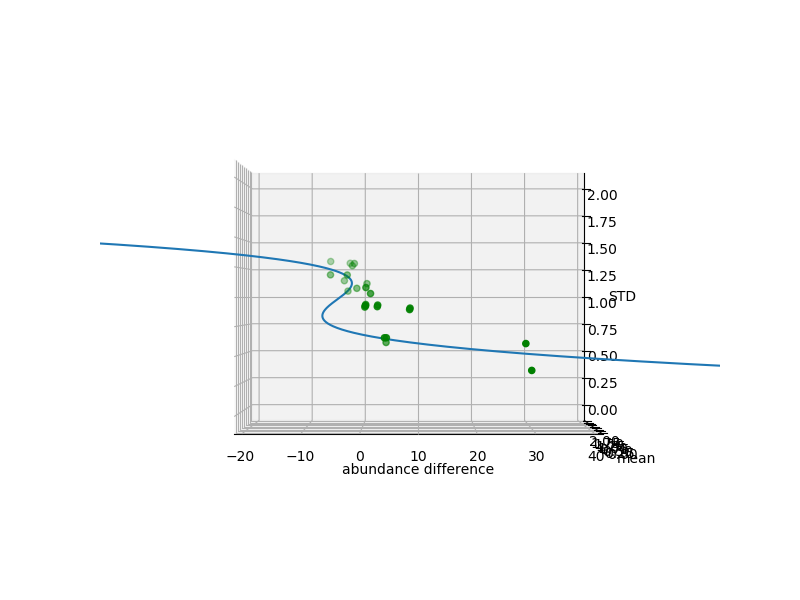

In [6]:
%matplotlib notebook
%run data_path.ipynb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mpl_toolkits import mplot3d
import numpy as np

loman = [7.32,  2.56,  0.24, -0.72, -2.01, -2.07, -2.30, -2.72, -0.08, -0.22]

sample="HybridR10v2"
k=3
gram = gram_pos
regr_df = pd.read_excel("regression_data.xlsx")
# regr_df.rename(columns={"ratio diff.":"diff_ratio", "relative avg":"r_avg", "relative std":"r_std"}, inplace=True)
# print(regr_df.columns.values)
test_df = regr_df[regr_df.data_type == sample]
train_df = regr_df[regr_df.data_type != sample]
# train_df = train_df[train_df.data_type != "BBv1"]
train_df = train_df[train_df.data_type != "MPZv1"]
# display(train_df)

train_df = train_df[train_df.species.isin(gram)]
test_df = test_df[test_df.species.isin(gram)]
# train_df = train_df[~train_df.species.isin(fungi)]
# test_df = test_df[~test_df.species.isin(fungi)]
# train_df = train_df[train_df.species != "Lactobacillus"]
# test_df = test_df[test_df.species != "Lactobacillus"]
display(test_df)

train_x = train_df[["r_avg","r_std"]].values.tolist()
train_y = train_df["diff_ratio"].values.tolist()
# train_x = [[x*100,y*100] for x,y in train_x]
train_y = [x*100 for x in train_y]
test_x = test_df[["r_avg","r_std"]].values.tolist()
test_y = test_df["diff_ratio"].values.tolist()
# test_x = [[x*100,y*100] for x,y in test_x]
test_y = [x*100 for x in test_y]
# print(test_y)

poly = PolynomialFeatures(degree=k)
# X_ = np.array(train_x)
# tX_ = np.array(test_x)
# X_ = np.hstack([X_**(i+1) for i in np.arange(k)])
# testX_ = np.hstack([tX_**(i+1) for i in np.arange(k)])
# np.append(X_,[1])
# np.append(testX_,[1])
X_ = poly.fit_transform(train_x)
testX_ = poly.fit_transform(test_x)
model = LinearRegression()
model.fit(X_, train_y)
pred_y = model.predict(testX_)
# print(pred_y)
print()
print("RMSE: ",np.sqrt(mean_squared_error(test_y, pred_y)))
pred_df = test_df.copy()
pred_df.drop(["data_type"], inplace=True, axis=1)
pred_df.insert(loc=2,column="pred_ratio", value=pred_y)

pred_df.diff_ratio = pred_df.diff_ratio * 100 + 12
pred_df.rename(columns={"diff_ratio":"origin_ratio"}, inplace=True)
pred_df.eval('pred_ratio = origin_ratio - pred_ratio', inplace=True)
display(pred_df.round(2))

tx1,tx2 = zip(*test_x)
trx1,trx2 = zip(*train_x)
line_x1 = np.linspace(0,2,1000)
line_x2 = np.linspace(0,2,1000)
x12=list(zip(line_x1,line_x2))
# X12_ = np.array(x12)
# x12_ = np.hstack([X12_**(i+1) for i in np.arange(k)])
# np.append(x12_,[1])
x12_ = poly.fit_transform(x12)
line_y = model.predict(x12_)
# line_x1, line_x2 = np.meshgrid(line_x1, line_x2)

pt = {
   "linep":{
       "ratio":line_y,
       "mean":line_x1,
       "std":line_x2
   },
    "trainp":{
       "ratio":train_y,
       "mean":trx1,
       "std":trx2
   },
    "testp":{
       "ratio":test_y,
       "mean":tx1,
       "std":tx2
   }
}
def ratio_coord_limit(ax,dx,dy,dz):
    if dx == "ratio":
        ax.set_xlim3d(-20,40)
    if dy == "ratio":
        ax.set_ylim3d(-20,40)
    if dz == "ratio":
        ax.set_zlim3d(-20,40)

def plot_regre(dx,dy,dz):
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    ax.set_xlabel("abundance difference")
    ax.set_ylabel("mean")
    ax.set_zlabel("STD")
    ratio_coord_limit(ax,dx,dy,dz)
    ax.plot3D(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz])
#     ax.plot_wireframe(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz], rcount=10,ccount=20)
    ax.scatter3D(pt["trainp"][dx], pt["trainp"][dy], pt["trainp"][dz],c='green')
    ax.scatter3D(pt["testp"][dx], pt["testp"][dy], pt["testp"][dz],c='g')
    ax.view_init(0,-90)
    plt.show()
    plt.savefig("overfit_model.png", dpi=330)

# dxyz = ("ratio", "mean", "std")
# plot_regre(*dxyz)
dxyz2 = ("ratio", "std", "mean")
plot_regre(*dxyz2)




In [ ]:
dx,dy,dz = ("ratio", "mean", "std")
pt = {
   "linep":{
       "ratio":line_y
       "mean":line_x1
       "std":line_x2
   }
    "trainp":{
       "ratio":train_y
       "mean":trx1
       "std":trx2
   }
    "testp":{
       "ratio":test_y
       "mean":tx1
       "std":tx2
   }
}


    ax.plot3D(pt["linep"][dx], pt["linep"][dy], pt["linep"][dz])
    ax.scatter3D(pt["trainp"][dx], pt["trainp"][dy], pt["trainp"][dz],c='green')
    ax.scatter3D(pt["testp"][dx], pt["testp"][dy], pt["testp"][dz],c='red')